In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model

In [2]:
mkdir checkpoints

In [3]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [6]:
def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    model = Sequential()

    #Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    #Decoder    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
    
    return model

model = UNET()
model.summary()

2022-09-23 18:54:49.065910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:54:49.178642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:54:49.179588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:54:49.181691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      2

In [7]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [8]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

2022-09-23 18:54:55.997255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-23 18:54:58.638594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 16s 136ms/step - loss: 0.4744 - accuracy: 0.7688 - dice_coef: 0.4934 - IOU: 0.3308 - specificity: 0.8383 - recall: 0.7192 - precision: 0.6024 - val_loss: 0.5004 - val_accuracy: 0.7523 - val_dice_coef: 0.2213 - val_IOU: 0.1244 - val_specificity: 1.0000 - val_recall: 2.7816e-05 - val_precision: 1.0000

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 5s 98ms/step - loss: 0.2820 - accuracy: 0.8580 - dice_coef: 0.6345 - IOU: 0.4655 - specificity: 0.9486 - recall: 0.7228 - precision: 0.8492 - val_loss: 0.6890 - val_accuracy: 0.7523 - val_dice_coef: 0.0783 - val_IOU: 0.0408 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 5s 97ms/step - loss: 0.2337 - accuracy: 0.8660 - dice_coef: 0.6783 - IOU: 0.5140 - specificity: 0.9590 - recall: 0.7242 - precision: 0.8797 - val_loss: 0.8454 

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [11]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.474423,0.768797,0.493353,0.330758,0.838338,0.719195,0.602442,0.500403,0.752274,0.221264,0.124422,1.000000,0.000028,1.000000,0.001
1,0.282030,0.858041,0.634475,0.465516,0.948566,0.722791,0.849165,0.689030,0.752267,0.078313,0.040753,1.000000,0.000000,0.000000,0.001
2,0.233693,0.865982,0.678282,0.513953,0.958982,0.724227,0.879720,0.845432,0.752267,0.037849,0.019289,1.000000,0.000000,0.000000,0.001
3,0.210812,0.869002,0.703287,0.542732,0.963083,0.723407,0.891789,0.899610,0.752267,0.029545,0.014993,1.000000,0.000000,0.000000,0.001
4,0.185362,0.875023,0.734111,0.580339,0.966991,0.742458,0.907508,1.045714,0.752267,0.014931,0.007521,1.000000,0.000000,0.000000,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.072266,0.906358,0.893456,0.807480,0.983845,0.851014,0.972909,0.150736,0.886441,0.837327,0.720518,0.983204,0.749377,0.964823,0.001
91,0.069062,0.907352,0.897631,0.814293,0.984805,0.853227,0.975769,0.127300,0.892532,0.859264,0.753491,0.983423,0.785304,0.970240,0.001
92,0.070052,0.907044,0.896390,0.812265,0.984319,0.853747,0.974482,0.129002,0.891906,0.857927,0.751453,0.982736,0.786680,0.967396,0.001
93,0.070081,0.907065,0.896485,0.812415,0.984469,0.853178,0.974727,0.093482,0.899023,0.880698,0.786876,0.979172,0.841033,0.961069,0.001


In [12]:
model.save('unet_three.h5')

In [13]:
pred = model.predict(X_test)

In [14]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9633297663862987

In [15]:
pred.shape

(93, 512, 512, 1)

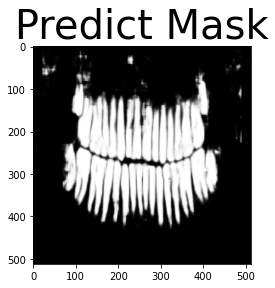

In [16]:
# plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

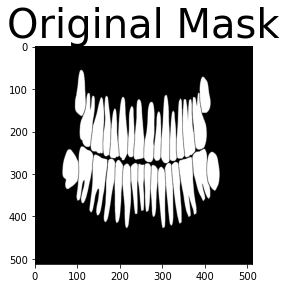

In [17]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')